# Simplicial Homology of Simplicial Complexes

The goal of this notebook is to implement, starting with a class for simplices, a program that allows the user to input a simplicial complex and compute its simplicial homology.
The mathematical way of doing this felt very algorithmic, and so it seemed like a fun idea to try to implement.
We also, using matplotlab, write a function to visualize these simplicial complexes, which are really just a combinatorial way to try to study shapes. We show some examples at the end.

We first need a Simplex class so that we have a notion of the boundary of a simplex. This will be useful when trying to define the chain complex differentials in the simplicial chain complex.

In [ ]:
class Simplex:
    def __init__(self, vertices):
        self.vertices = tuple(sorted(vertices))

    @property
    def dimension(self):
        return len(self.vertices) - 1

    def __len__(self):
        return len(self.vertices)
        
    def boundary(self):
        if self.dimension == 0:
            return []
        return [Simplex(self.vertices[:i] + self.vertices[i+1:]) for i in range(self.dimension + 1)]


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

class SimplicialComplex:
    def __init__(self, simplices=[]):
        self.simplices = [Simplex(s) for s in simplices]
        self._max_dim = None

    def add_simplex(self, s):
        simplex = Simplex(s)
        self.simplices.append(simplex)
        # Resetting cached value of max_dim
        self._max_dim = None

    @property
    def max_dim(self):
        if self._max_dim is None:
            if self.simplices:
                self._max_dim = max(len(s) for s in self.simplices) - 1
            else:
                self._max_dim = -1
        return self._max_dim

    def _k_simplices(self, k):
        return [s for s in self.simplices if len(s) == k + 1]

    def _boundary_matrix(self, k):
        # Get k-simplices and (k-1)-simplices
        k_simplices = self._k_simplices(k)
        k_minus_1_simplices = self._k_simplices(k-1)

        # Initialize a matrix of zeros
        matrix = np.zeros((len(k_minus_1_simplices), len(k_simplices)), dtype=int)

        # Fill the matrix
        for j, ks in enumerate(k_simplices):
            for boundary in ks.boundary():
                if boundary in k_minus_1_simplices: # Adding this check
                    i = k_minus_1_simplices.index(boundary)
                    matrix[i, j] = (-1) ** ks.vertices.index(boundary.vertices[0])

        return matrix

    def compute_homology(self):
        homology_groups = {}
        
        for k in range(1, self.max_dim + 2):
            boundary_k = self._boundary_matrix(k)
            boundary_k_plus_1 = self._boundary_matrix(k+1)
    
            # Using numpy to compute the ranks
            rank_boundary_k = np.linalg.matrix_rank(boundary_k) if boundary_k.size else 0
            rank_boundary_k_plus_1 = np.linalg.matrix_rank(boundary_k_plus_1) if boundary_k_plus_1.size else 0
    
            # Compute the Betti number and ensure it's non-negative
            betti_k = max(0, len(self._k_simplices(k-1)) - rank_boundary_k - rank_boundary_k_plus_1)
            homology_groups[k-1] = betti_k
    
        return homology_groups
        
    def visualize(self):
        dim = self.max_dim + 1
        
        fig = plt.figure()
        
        if dim == 1:
            xs = [s.vertices[0][0] for s in self._k_simplices(0)]
            ys = [0] * len(xs)  # Create ys to match xs
            plt.scatter(xs, ys)
        
        elif dim == 2:
            ax = fig.add_subplot(111)
            for s in self._k_simplices(1):
                xs, ys = zip(*s.vertices)
                ax.plot(xs, ys, 'b-')
            xs, ys = zip(*[s.vertices[0] for s in self._k_simplices(0)])
            ax.scatter(xs, ys, c='r')
        
        elif dim == 3:
            ax = fig.add_subplot(111, projection='3d')
            for s in self._k_simplices(2):
                verts = [list(s.vertices)]
                ax.add_collection3d(Poly3DCollection(verts, alpha=.25, linewidths=1, edgecolors='r'))
            for s in self._k_simplices(1):
                xs, ys, zs = zip(*s.vertices)
                ax.plot(xs, ys, zs, 'b-')
            xs, ys, zs = zip(*[s.vertices[0] for s in self._k_simplices(0)])
            ax.scatter(xs, ys, zs, c='r')
        
        else:
            raise ValueError(f"Cannot visualize dimension {dim-1}")
        
        plt.show()

# First, we implement just a standard 2-simplex

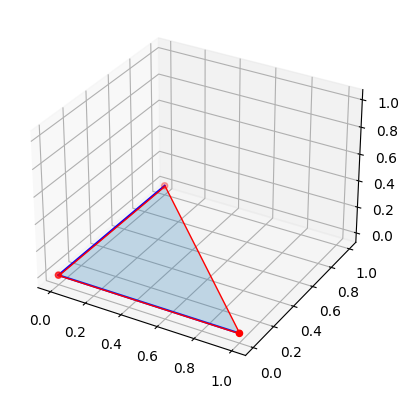

In [38]:
# Example Usage
# For 2D visualization
sc = SimplicialComplex()
sc.add_simplex([(0, 0, 0)])
sc.add_simplex([(1, 0, 0)])
sc.add_simplex([(0, 1, 0)])
sc.add_simplex([(0, 0, 0), (1, 0, 0)])
sc.add_simplex([(0, 0, 0), (0, 1, 0)])
sc.add_simplex([(0, 0, 0), (1, 0, 0), (0, 1, 0)])
sc.visualize()

# We can also do more complicated shapes like tetrahedrons!

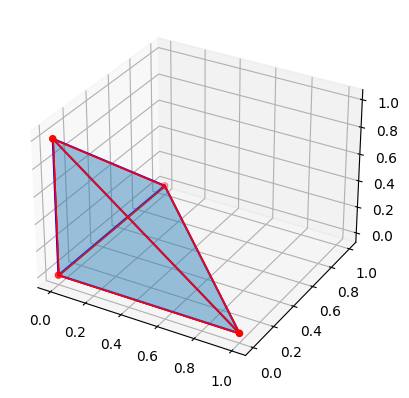

In [37]:
sc_tetrahedron = SimplicialComplex()

# Adding vertices
sc_tetrahedron.add_simplex([(0, 0, 0)])  # Vertex A
sc_tetrahedron.add_simplex([(1, 0, 0)])  # Vertex B
sc_tetrahedron.add_simplex([(0, 1, 0)])  # Vertex C
sc_tetrahedron.add_simplex([(0, 0, 1)])  # Vertex D

# Adding edges
sc_tetrahedron.add_simplex([(0, 0, 0), (1, 0, 0)])  # Edge AB
sc_tetrahedron.add_simplex([(0, 0, 0), (0, 1, 0)])  # Edge AC
sc_tetrahedron.add_simplex([(0, 0, 0), (0, 0, 1)])  # Edge AD
sc_tetrahedron.add_simplex([(1, 0, 0), (0, 1, 0)])  # Edge BC
sc_tetrahedron.add_simplex([(1, 0, 0), (0, 0, 1)])  # Edge BD
sc_tetrahedron.add_simplex([(0, 1, 0), (0, 0, 1)])  # Edge CD

# Adding triangular faces
sc_tetrahedron.add_simplex([(0, 0, 0), (1, 0, 0), (0, 1, 0)])  # Triangle ABC
sc_tetrahedron.add_simplex([(0, 0, 0), (1, 0, 0), (0, 0, 1)])  # Triangle ABD
sc_tetrahedron.add_simplex([(0, 0, 0), (0, 1, 0), (0, 0, 1)])  # Triangle ACD
sc_tetrahedron.add_simplex([(1, 0, 0), (0, 1, 0), (0, 0, 1)])  # Triangle BCD
sc_tetrahedron.visualize()